# Exploring and Validating code for the improc module

In [1]:
%matplotlib inline
import os
import math
import numpy as np
import timeit
import sys
import matplotlib.pyplot as plt
from IPython.display import Image
from scipy import ndimage
from sklearn.preprocessing import Imputer

In [2]:
sys.path.append(os.path.join(sys.path[0], '..'))
import improc

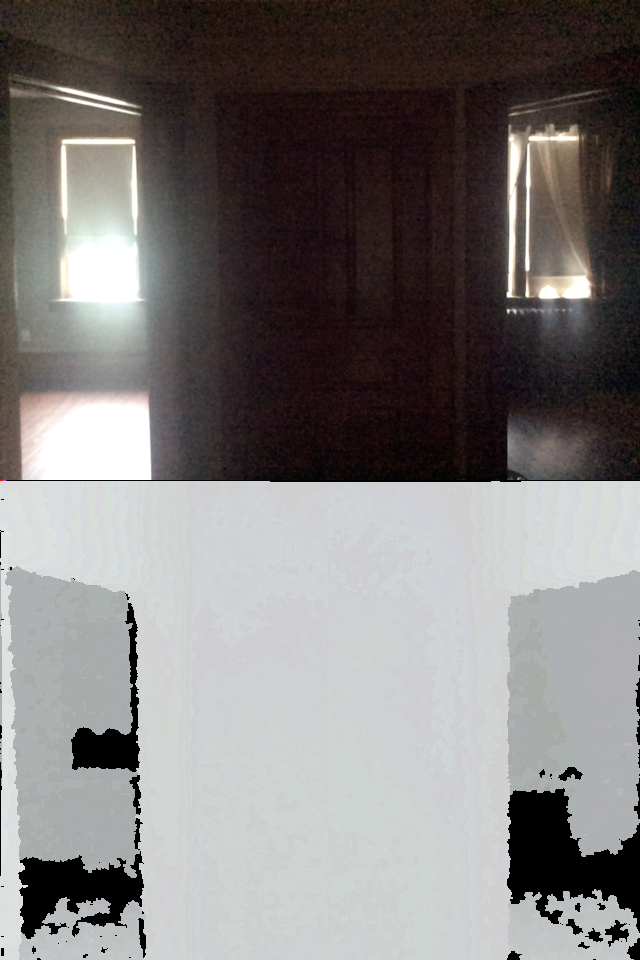

In [3]:
test_path = "../captures/orient/orient - 1.PNG"
Image(filename=test_path)

In [4]:
combined_image = ndimage.imread(test_path)
combined_image.shape

(960, 640, 3)

In [5]:
def split(image):
    """Take a color/depth image pair and split out the two parts."""
    split_height = image.shape[0] // 2
    return image[:split_height], image[split_height:]
camera_image, depth_image = split(combined_image)
print(camera_image.shape, depth_image.shape)

(480, 640, 3) (480, 640, 3)


In [6]:
depth_image[0].shape

(640, 3)

# Naive python code for decoding depth (slow)

In [7]:
def convert_to_depth(image):
    height = image.shape[0]
    width = image.shape[1]
    depths = np.zeros((height, width), dtype=np.float32)
    BYTE_MAX = 255
    CHANNEL_MAX = 8
    MAX_RED_VALUE = BYTE_MAX - CHANNEL_MAX
    CHANNELS_MAX = CHANNEL_MAX * CHANNEL_MAX
    INVALID = float('Nan')

    def byteToUnit(value):
        return ((2.0 * value) / BYTE_MAX) - 1
    
    to_decode = []
    decoded = []
    next_decode = None
    attitude = {
        "quaternion": [1, 0, 0, 0],
        "euler": [0, 0, 0],
        "matrix": [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
    }
    for y in range(0, height):
        row = image[y]
        depth_row = depths[y]
        for x in range(0, width):
            pixel = row[x]
            red = pixel[0]
            if (x == 0 or x == 2) and y == 0 and red == BYTE_MAX:
                if x == 0:
                    to_decode = ["quaternion"]
                else:
                    to_decode = ["euler", 0, 1, 2]
                depth_row[x] = INVALID
                continue
            if to_decode:
                entry = to_decode.pop(0)
                if entry == "quaternion":
                    quaternion = attitude[entry]
                    for c in range(0, 3):
                        quaternion[c] = byteToUnit(pixel[c])
                elif entry == "euler":
                    euler = attitude[entry]
                    for c in range(0, len(euler)):
                        euler[c] = math.pi * byteToUnit(pixel[c])
                else:
                    matrix = attitude["matrix"]
                    matrix_row = matrix[entry]
                    for c in range(0, len(matrix_row)):
                        matrix_row[c] = byteToUnit(pixel[c])
                depth_row[x] = INVALID
                continue
            if red == 0:
                depth_row[x] = INVALID
                continue
            green = pixel[1] - red
            blue = pixel[2] - red
            depth_row[x] = (MAX_RED_VALUE - red)*CHANNELS_MAX + green*CHANNEL_MAX + blue 
    return depths, attitude

In [8]:
depths, attitude = convert_to_depth(depth_image)

In [9]:
depths.shape

(480, 640)

In [10]:
attitude

{'euler': [-1.5646363411996225, -0.012319971190548165, 1.4167966869130437],
 'matrix': [[0.0039215686274509665, 0.011764705882352899, 0.99215686274509807],
  [-0.99215686274509807, 0.13725490196078427, 0.0039215686274509665],
  [-0.14509803921568631, -0.99215686274509807, 0.011764705882352899]],
 'quaternion': [0.45882352941176463,
  -0.52941176470588236,
  0.45882352941176463,
  0]}

In [11]:
a = np.array(attitude["quaternion"])

In [12]:
a2 = a * a
a2

array([ 0.21051903,  0.28027682,  0.21051903,  0.        ])

In [13]:
a2sum = np.sum(a2[0:3])
a2sum

0.70131487889273347

In [14]:
w = np.sqrt(1 - a2sum)
w

0.54652092467467939

In [15]:
a[3] = w

In [16]:
np.sum(a * a)

1.0

In [17]:
a

array([ 0.45882353, -0.52941176,  0.45882353,  0.54652092])

In [18]:
depths[120][300:310]

array([ 2628.,  2628.,  2628.,  2628.,  2628.,  2628.,  2628.,  2628.,
        2605.,  2605.], dtype=float32)

In [19]:
depths[0][0:20]

array([ nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan], dtype=float32)

In [20]:
timeit.timeit(
    "depths, attitude = convert_to_depth(depth_image)",
    number=10,
    setup="from __main__ import convert_to_depth, depth_image"
)

20.55553467900245

# Numpy rewrite of decoding (much faster)

In [21]:
def decode_depth(image):
    BYTE_MAX = 255
    CHANNEL_MAX = 8.0
    MAX_RED_VALUE = BYTE_MAX - CHANNEL_MAX
    CHANNELS_MAX = CHANNEL_MAX * CHANNEL_MAX
    
    def byteToUnit(value):
        return ((2.0 * value) / BYTE_MAX) - 1
    
    attitude = {
        "quaternion": [1, 0, 0, 0],
        "euler": [0, 0, 0],
        "matrix": [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
    }
    leading_nans = 0
    
    if np.array_equal(image[0, 0], [BYTE_MAX, 0, 0, BYTE_MAX]):
        pixel = image[0, 1]
        orientation = attitude["quaternion"]
        for c in range(len(orientation)):
            orientation[c] = byteToUnit(pixel[c])
        leading_nans += 2
        
    if np.array_equal(image[0, 2], [BYTE_MAX, 0, 0, BYTE_MAX]):
        pixel = image[0, 3]
        orientation = attitude["euler"]
        for c in range(len(orientation)):
            orientation[c] = math.pi * byteToUnit(pixel[c])
        matrix = attitude["matrix"]
        for r in range(len(matrix)):
            pixel = image[0, 4 + r]
            row = matrix[r]
            for c in range(len(row)):
                row[c] = byteToUnit(pixel[c])
        leading_nans += 5
        
    red = image[:, :, 0]
    green = image[:, :, 1] - red
    blue = image[:, :, 2] - red

    depth = (MAX_RED_VALUE - red)*CHANNELS_MAX + green*CHANNEL_MAX + blue
    depth[np.where(red == 0)] = np.nan
    depth[0, :leading_nans] = np.nan
    return depth, attitude

In [22]:
depths, attitude = decode_depth(depth_image)

In [23]:
depths.shape

(480, 640)

In [24]:
depths[120][300:310]

array([ 2628.,  2628.,  2628.,  2628.,  2628.,  2628.,  2628.,  2628.,
        2605.,  2605.])

In [25]:
depths[0][0:20]

array([  -503.,   4944.,   -503.,  12337.,   7750.,  17023.,  10036.,
           nan,     nan,     nan,     nan,     nan,     nan,     nan,
           nan,     nan,     nan,     nan,     nan,     nan])

In [26]:
attitude

{'euler': [0, 0, 0],
 'matrix': [[1, 0, 0], [0, 1, 0], [0, 0, 1]],
 'quaternion': [1, 0, 0, 0]}

In [27]:
timeit.timeit(
    "depths, attitude = decode_depth(depth_image)",
    number=10,
    setup="from __main__ import decode_depth, depth_image"
)

0.10037276500224834

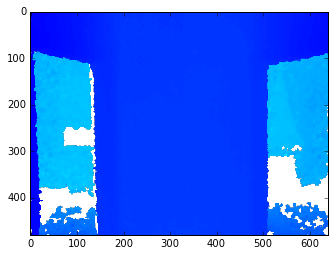

In [28]:
plt.imshow(depths)

# Filling holes with sklearn's Imputer
Replaces NaN with mean/max of row or column

In [29]:
imp = Imputer(strategy="mean")
cleaned = imp.fit_transform(depths)

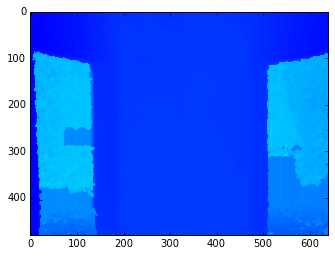

In [30]:
plt.imshow(cleaned)

In [31]:
depths[330,0]

nan

In [32]:
cleaned[330,0]

3404.2282958199357

# Filling holes with block mean
Replace NaN with mean/max of corresponding 15x20 pixel blocks

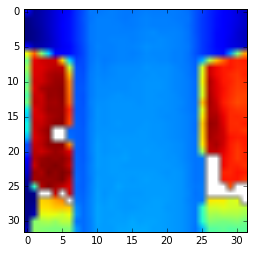

In [33]:
reshaped = depths.copy().reshape(32, 15, 32, 20)
masked = np.ma.masked_array(reshaped, np.isnan(reshaped))
masked_means = np.mean(np.mean(masked, axis=3), axis=1)
means = masked_means.filled(np.nan)
plt.imshow(means)

(480, 640)


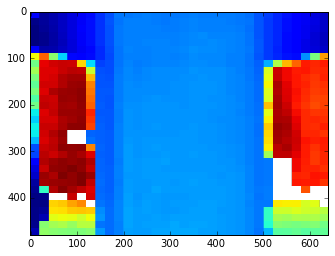

In [34]:
expanded = np.repeat(means,20,axis=1).reshape(32,640)
expanded = np.repeat(expanded,15,axis=0).reshape(480,640)
print(expanded.shape)
plt.imshow(expanded)

In [35]:
ind = np.where(np.isnan(depths))
cleaned = depths.copy()
cleaned[ind] = expanded[ind]

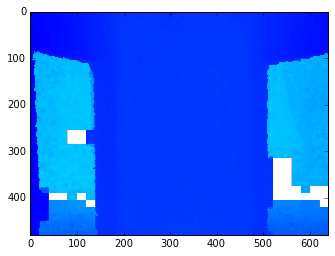

In [36]:
plt.imshow(cleaned)

# Fill NaNs with localized stat values using mipmaps
Combined this: http://stackoverflow.com/questions/14549696/mipmap-of-image-in-numpy

With this: http://stackoverflow.com/questions/5480694/numpy-calculate-averages-with-nans-removed

In [37]:
def mipmap_imputer(image, strategy=np.mean, scales=None):
    scales = scales if scales else [(5,5), (3,2), (2,2), (2,2), (2,2), (2,2), (2,2), (1,2)]
    mipmaps = []
    mipmap = image
    for y, x in scales:
        mipmap = mipmap.copy()
        size = mipmap.shape
        reshaped = mipmap.reshape(size[0] // y, y, size[1] // x, x)
        masked = np.ma.masked_array(reshaped, np.isnan(reshaped))
        mipmap = strategy(strategy(masked, axis=3), axis=1).filled(np.nan)
        mipmaps.append(mipmap)
    
    for index, mipmap in reversed(list(enumerate(mipmaps))):
        y, x = scales[index]
        expanded = mipmap
        if x > 1:
            x_size = expanded.shape[1] * x
            expanded = np.repeat(expanded, x, axis=1).reshape(expanded.shape[0], x_size)
        if y > 1:
            y_size = expanded.shape[0] * y
            expanded = np.repeat(expanded, y, axis=0).reshape(y_size, expanded.shape[1])
        target = mipmaps[index - 1] if index > 0 else image.copy()

        nans = np.where(np.isnan(target))
        target[nans] = expanded[nans]
    return target

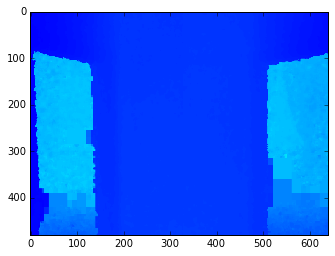

In [38]:
cleaned = mipmap_imputer(depths)
plt.imshow(cleaned)

In [39]:
timeit.timeit(
    "cleaned = mipmap_imputer(depths)",
    number=10,
    setup="from __main__ import mipmap_imputer,depths"
)

0.19069010500243166

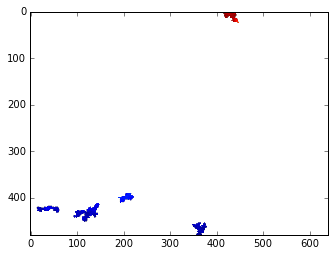

In [40]:
_, poor_depth = split(ndimage.imread("../testing/IMG_3410.PNG"))
poor_depths, _ = decode_depth(poor_depth)
plt.imshow(poor_depths)

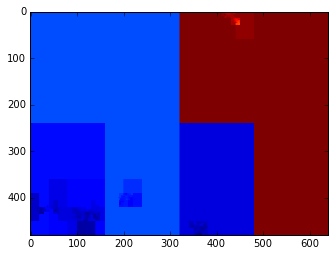

In [41]:
plt.imshow(mipmap_imputer(poor_depths, strategy=np.max))

# Add Smoothing

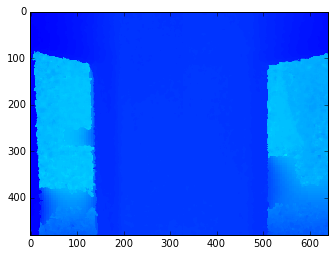

In [42]:
smoothed = improc.mipmap_imputer(depths, smooth=True)
plt.imshow(smoothed)

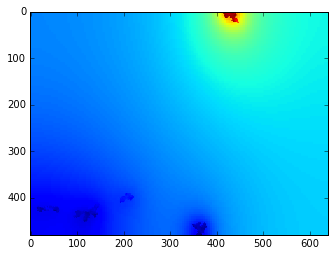

In [43]:
poor_smoothed = improc.mipmap_imputer(poor_depths, smooth=True)
plt.imshow(poor_smoothed)

# Make Noise

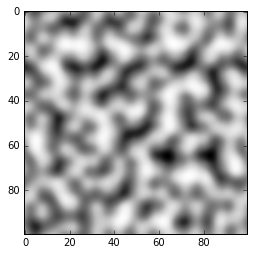

In [44]:
noise = noise = improc.PerlinNoise(10, 10, np.random.RandomState(20202))
improc.make_noise(100, 100, 10, 10, )
plt.imshow(noise.fill(100,100,0,10,0,10), cmap='Greys_r')

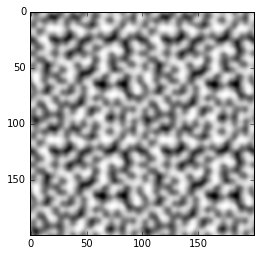

In [45]:
plt.imshow(noise.fill(200,200,0,20,0,20), cmap='Greys_r')

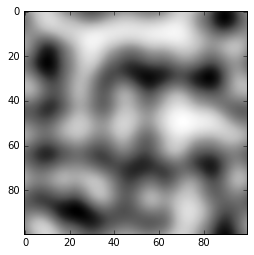

In [46]:
noise = improc.make_noise(100, 100, 5, 5, np.random.RandomState(12345))
plt.imshow(noise, cmap='Greys_r')

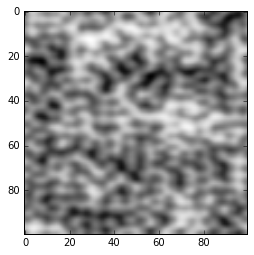

In [47]:
noise += improc.make_noise(100, 100, 20, 15, np.random.RandomState(54321))
plt.imshow(noise, cmap='Greys_r')

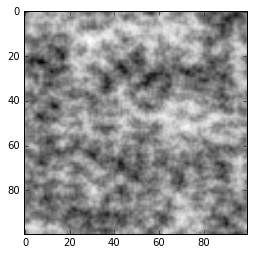

In [48]:
noise += 0.5 * improc.make_noise(100, 100, 50, 50, np.random.RandomState(12321))
plt.imshow(noise, cmap='Greys_r')